In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

from sklearn.metrics import r2_score

import numpy as np

from tqdm import tqdm
from datetime import timedelta  

import warnings
warnings.filterwarnings(action='ignore')

/home/lee/.pyenv/versions/machine_learning/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [9]:
def plot_line(df, title):
    fig = px.line(df, x = 'date', y = 'count', title = title)
    fig.show()
    
def filter_column(df, column, border_low, border_high):
    filter_mask = (df[column] >= border_low) & (df[column] < border_high)
    
    filtered_df = df[filter_mask].reset_index(drop=True)
    return filtered_df

def convert_columns(df):
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    return df

In [3]:
train_data = pd.read_csv("../dataset/train_test/train.csv")
test_data = pd.read_csv("../dataset/train_test/test.csv")

train_data = train_data[['date', 'count']]
test_data = test_data[['date', 'count']]

data = pd.concat([train_data, test_data])

data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')

train_data['date'] = pd.to_datetime(train_data['date'])
train_data = train_data.set_index('date')

test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.set_index('date')

In [6]:
# data = pd.read_csv("dataset/in_total.csv", thousands=r',', encoding='utf-8')

# criterion_low = pd.Timestamp(2015, 9,19)
# criterion_high = pd.Timestamp(2020, 1,1)

# train_data = filter_column(data, 'date', criterion_low, criterion_high)

# criterion_low = pd.Timestamp(2020, 1,1)
# criterion_high = pd.Timestamp(2020, 6,30)

# test_data = filter_column(data, 'date', criterion_low, criterion_high)

In [4]:
diff_train_data = train_data.copy()
diff_train_data1 = diff_train_data['count'].diff()
diff_train_data1 = diff_train_data1.dropna()
diff_train_data2 = diff_train_data1.diff()
diff_train_data2 = diff_train_data2.dropna()

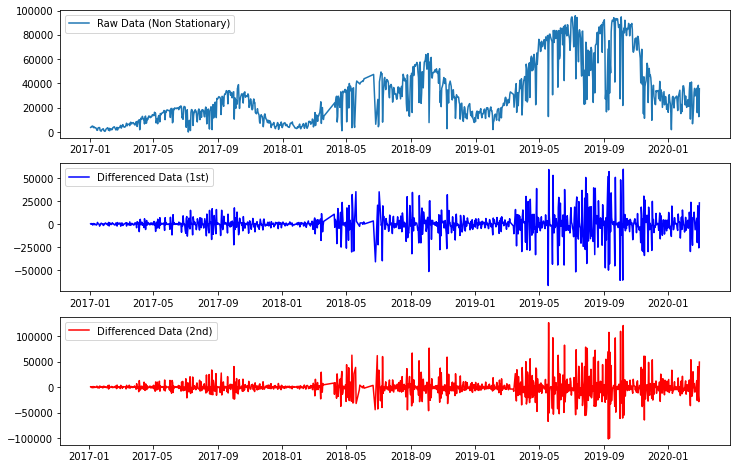

In [5]:
plt.figure(figsize = (12, 8))
plt.subplot(311)
plt.plot(train_data['count'])
plt.legend(['Raw Data (Non Stationary)'])
plt.subplot(312)
plt.plot(diff_train_data1, 'blue')
plt.legend(['Differenced Data (1st)'])
plt.subplot(313)
plt.plot(diff_train_data2, 'red')
plt.legend(['Differenced Data (2nd)'])
plt.show()

In [10]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
import pandas as pd

class StationarityTests:
    def __init__(self, significance = .05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        
    def ADF_Stationarity_Test(self, timeseries, printResults = True):

        #Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')
        
        self.pValue = adfTest[1]
        
        if (self.pValue<self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value

            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)
            
# sTest = StationarityTests()
# sTest.ADF_Stationarity_Test(diff_train_data1, printResults = True)
# print("Is the time series stationary? {0}".format(sTest.isStationary))

for datum in [train_data, diff_train_data1, diff_train_data2]:
    sTest = StationarityTests()
    sTest.ADF_Stationarity_Test(datum, printResults = True)
    print("Is the time series stationary? {0}".format(sTest.isStationary))

Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -1.867390
P-Value                    0.347554
# Lags Used               13.000000
# Observations Used     1071.000000
Critical Value (1%)       -3.436470
Critical Value (5%)       -2.864242
Critical Value (10%)      -2.568209
dtype: float64
Is the time series stationary? False
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.381863e+01
P-Value                 7.981793e-26
# Lags Used             1.200000e+01
# Observations Used     1.071000e+03
Critical Value (1%)    -3.436470e+00
Critical Value (5%)    -2.864242e+00
Critical Value (10%)   -2.568209e+00
dtype: float64
Is the time series stationary? True
Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -1.403730e+01
P-Value                 3.351573e-26
# Lags Used             2.200000e+01
# Observations Used     1.060000e+03
Critical Value (1%)    -3.436534e+00
Critical Value (5%)    -2.864270e+00
Critical Value (10%)   -2.568224e+00
dtype: float6

In [49]:
def arima_model_gen(train, season = False, trace = False):
    arima_model = pm.arima.auto_arima(train, start_p=1, start_q=1,
                           max_p=2, max_q=2, m=12,
                           start_P=0, seasonal = season,
                           d=1, D=1, trace=trace,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    return arima_model

def arima_predict_daily(model, train, season = False):
    if season:
        amodel_opt = SARIMAX(train.values, order=model.order)
        
    else:
        amodel_opt = ARIMA(train.values, order = model.order)
    amodel_opt_fit = amodel_opt.fit()

    prediction = amodel_opt_fit.forecast(1)
    predicted_value = prediction[0]

    return predicted_value

def daily_prediction(train, test, season=False, trace = False):
    train_ = train.copy()
    test_ = test.copy()
    
    predict_list = []

    for i in tqdm(range(len(test_))):
        daily_arima = arima_model_gen(train_, season=season, trace = trace)
        daily_prediction = arima_predict_daily(daily_arima, train_, season=season)
        predict_list.append(int(daily_prediction))
        train_.loc[test_.index[i]] = test_.values[i][0]

    result = pd.DataFrame(predict_list, index=test_.index, columns=['count'])
    return result

In [50]:
arima_result = daily_prediction(train_data, test_data, season = False)
arima_result.to_csv("arima_result/arima_result.csv")

sarima_result = daily_prediction(train_data, test_data, season = True)
sarima_result.to_csv("arima_result/sarima_result.csv")

100%|██████████| 122/122 [02:59<00:00,  1.47s/it]


In [16]:
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def r2(y_true, y_pred):
    return r2_score(y_true, y_pred)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def mean_absolute_percentage_error(y_true, y_pred): 
    return ((np.mean(np.abs((y_true - y_pred) / y_true)) * 100).values[0])

def smape(A, F):
    return (100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))).values[0]

def all_metric(y_true, y_pred):
    print(f'r2 score: {r2_score(y_true, y_pred)}')
    print(f'Mean Absolute Error: {mae(y_true, y_pred)}')
    print(f'Mean Squared Error: {mse(y_true, y_pred)}')
    print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'SMAPE: {smape(y_true, y_pred)}')

In [17]:
arima_result = pd.read_csv("arima_result/arima_result.csv")
sarima_result = pd.read_csv("arima_result/sarima_result.csv")   

arima_result = convert_columns(arima_result)
sarima_result = convert_columns(sarima_result)

In [19]:
all_metric(test_data, sarima_result)

r2 score: 0.4338376523873102
Mean Absolute Error: 13019.131147540984
Mean Squared Error: 355999830.2295082
Mean Absolute Percentage Error: 35.63247055290547
SMAPE: 21.267330146033764


In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split

sarima_model = pm.arima.auto_arima(train_data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=False)
print(sarima_model.aic())

In [93]:
from statsmodels.stats.diagnostic import acorr_ljungbox, acorr_breusch_godfrey
from scipy.stats import probplot, shapiro, jarque_bera
from sklearn.metrics import r2_score

In [42]:
def model_diagnostics(residuals, model_obj):
    # For Breusch-Godfrey we have to pass the results object
#     godfrey = acorr_breusch_godfrey(model_obj, nlags= 30)
    ljung = acorr_ljungbox(residuals, lags= 30)
    shap = shapiro(residuals)
    j_bera = jarque_bera(residuals)
    print('Results of Ljung-Box:')
    print('Null Hypothesis: No auto-correlation')
    print('P-Value =< Alpha(.05) : Reject Null')
    print(f'p-values: {ljung[1]}\n')
#     print('Results of Breusch-Godfrey:')
#     print('Null Hypothesis: No auotcorrelation')
#     print('P-Value =< Alpha(.05) => Reject Null')   
#     print(f'p-values: {godfrey[1]}\n')
    print('Results of Shapiro-Wilks:')
    print('Null Hypothesis: Data is normally distributed')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-value: {shap[1]}\n')
    print('Results of Jarque-Bera:')
    print('Null Hypothesis: Data is normally distributed')
    print('P-Value =< Alpha(.05) => Reject Null')   
    print(f'p-value: {j_bera[1]}')

def plot_diagnostics(residuals):
#     px.line(residuals, title='ARIMA Residuals',)
#     residuals.plot(title='ARIMA Residuals', figsize=(15, 10))
#     plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    ax[0].set_title('ARIMA Residuals KDE')
    ax[1].set_title('ARIMA Resduals Probability Plot')    
    pd.Series(residuals).plot(kind='kde', ax=ax[0])
    probplot(residuals, dist='norm', plot=ax[1])
    plt.show()

/usr/local/var/pyenv/versions/bigcontest/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Results of Ljung-Box:
Null Hypothesis: No auto-correlation
P-Value =< Alpha(.05) : Reject Null
p-values: [0.987991   0.9611126  0.57286587 0.24320292 0.32136841 0.34816496
 0.20765121 0.27840289 0.3645765  0.38038741 0.37120205 0.37070092
 0.4493993  0.52813004 0.44772156 0.48776084 0.53935629 0.59603589
 0.57392714 0.63758589 0.69181565 0.59427421 0.61730801 0.5920817
 0.53975234 0.57965054 0.59816613 0.59627804 0.63217902 0.66946514]

Results of Shapiro-Wilks:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 1.2751816025355835e-43

Results of Jarque-Bera:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 0.0


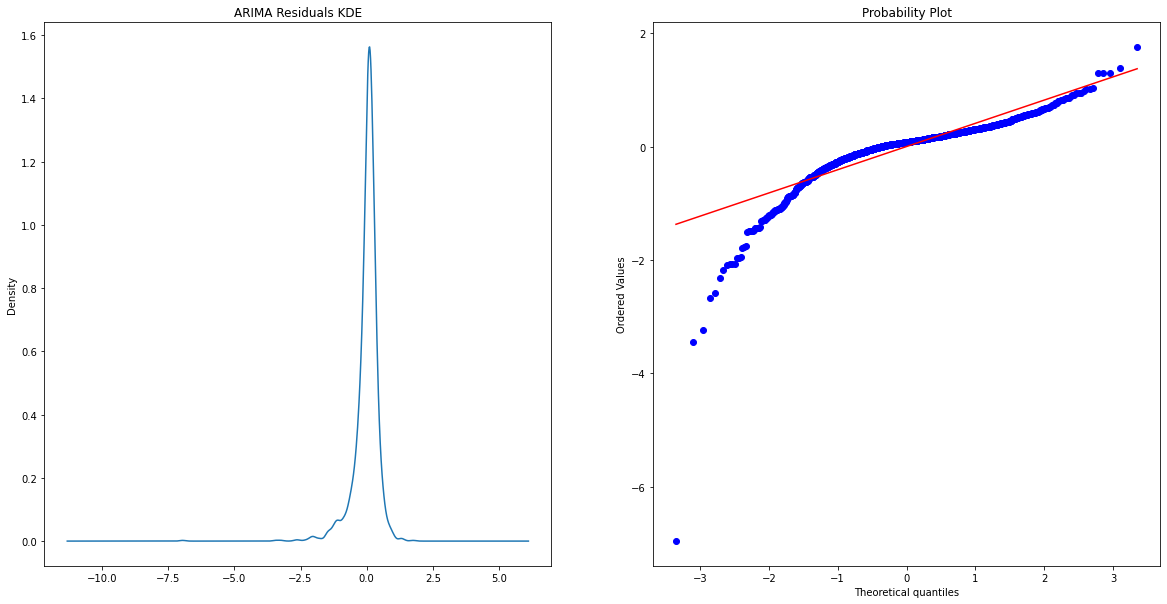

/usr/local/var/pyenv/versions/bigcontest/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


Results of Ljung-Box:
Null Hypothesis: No auto-correlation
P-Value =< Alpha(.05) : Reject Null
p-values: [0.88798377 0.83244236 0.68441048 0.33221614 0.46719708 0.47949292
 0.3733827  0.44810872 0.47014487 0.56486964 0.53602671 0.00561258
 0.00687853 0.00183085 0.00234585 0.00260324 0.00413041 0.00565817
 0.00833591 0.01035963 0.01484857 0.01796685 0.02322741 0.01819217
 0.02018447 0.02108671 0.01940179 0.01355858 0.01779435 0.02372175]

Results of Shapiro-Wilks:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 2.802596928649634e-45

Results of Jarque-Bera:
Null Hypothesis: Data is normally distributed
P-Value =< Alpha(.05) => Reject Null
p-value: 0.0


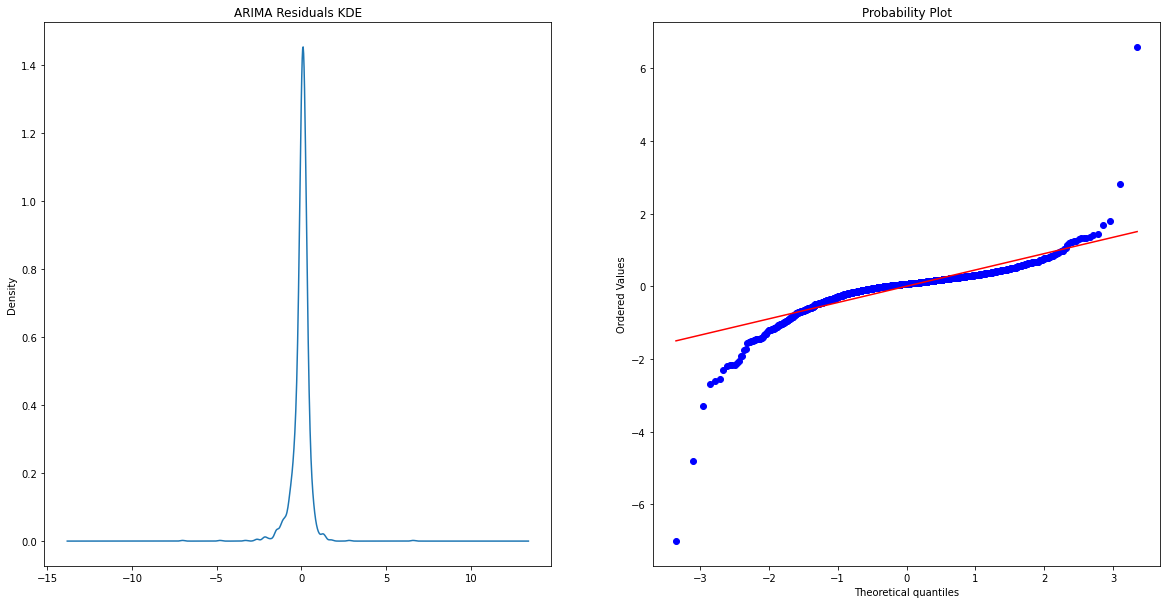

In [43]:
amodel_opt = ARIMA(train_data.values, order = arima_model.order)
amodel_opt_fit = amodel_opt.fit()
amodel_opt_fit.summary()

arima_resid = amodel_opt_fit.resid

model_diagnostics(arima_resid, amodel_opt_fit)
plot_diagnostics(arima_resid)

smodel_opt = SARIMAX(train_data.values, order = sarima_model.order, seasonal_order = sarima_model.seasonal_order)
smodel_opt_fit =smodel_opt.fit()
smodel_opt_fit.summary()

sarima_resid = smodel_opt_fit.resid

model_diagnostics(sarima_resid, smodel_opt_fit)
plot_diagnostics(sarima_resid)

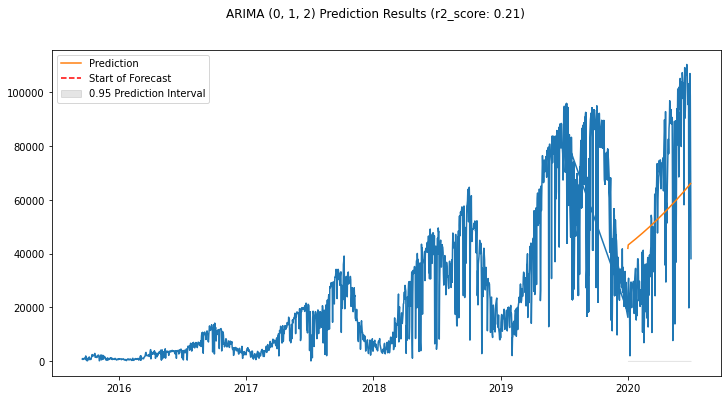

In [49]:
prediction = amodel_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_ub = prediction[2][:,0]
predicted_lb = prediction[2][:,1]
predict_index = list(test_data.index)

r2 = r2_score(test_data, predicted_value)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(data);

ax.vlines(test_data.index[0], 0, 125, linestyle='--', color = 'r', label ='Start of Forecast')
ax.plot(predict_index, np.exp(predicted_value), label = 'Prediction')

ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

ax.legend(loc = 'upper left')

plt.suptitle(f'ARIMA {arima_model.order} Prediction Results (r2_score: {round(r2, 2)})')
plt.show()

In [23]:
def plot_prediction(total, pred, test, title):
    r2 = r2_score(test, pred)
    predict_index = list(pred.index)

    fig, ax = plt.subplots(figsize = (12, 6))
    ax.plot(total);

    ax.vlines(test.index[0], 0, 100000, linestyle='--', color = 'r', label ='Start of Forecast')
    ax.plot(predict_index, pred.values, label = 'Prediction')

    # ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

    ax.legend(loc = 'upper left')

    plt.suptitle(f'{title} Prediction Results (r2_score: {round(r2, 2)})')
    plt.show()

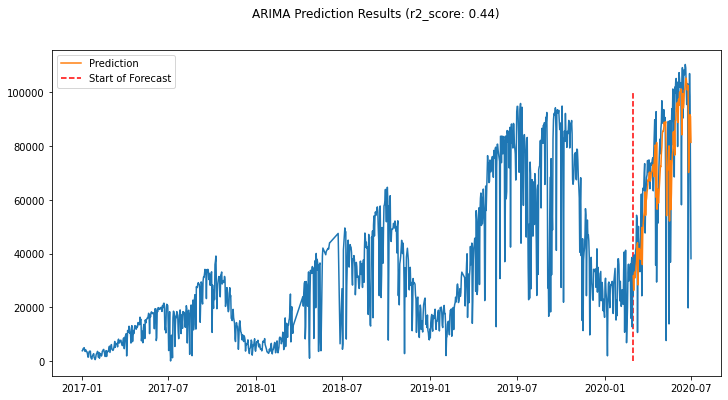

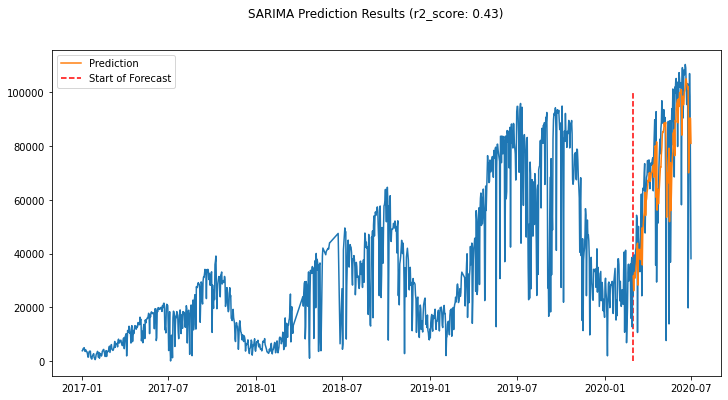

In [27]:
plot_prediction(data, arima_result, test_data, 'ARIMA')
plot_prediction(data, sarima_result, test_data, 'SARIMA')

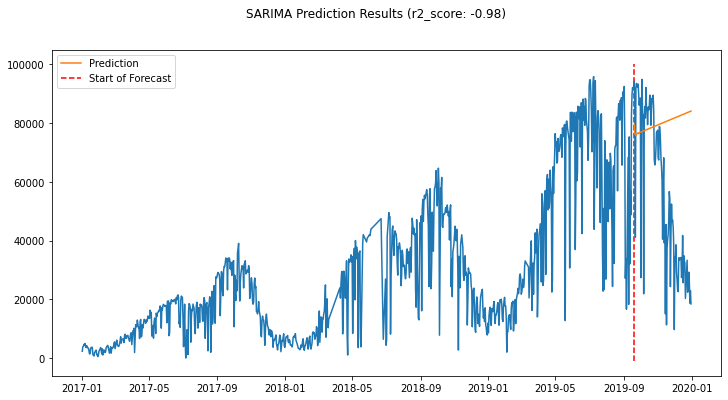

In [71]:
r2 = r2_score(test_data, sarima_result)
predict_index = list(sarima_result.index)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(data);

ax.vlines(test_data.index[0], -1000, 100000, linestyle='--', color = 'r', label ='Start of Forecast')
ax.plot(predict_index, sarima_result.values, label = 'Prediction')

# ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')

ax.legend(loc = 'upper left')

plt.suptitle(f'SARIMA Prediction Results (r2_score: {round(r2, 2)})')
plt.show()

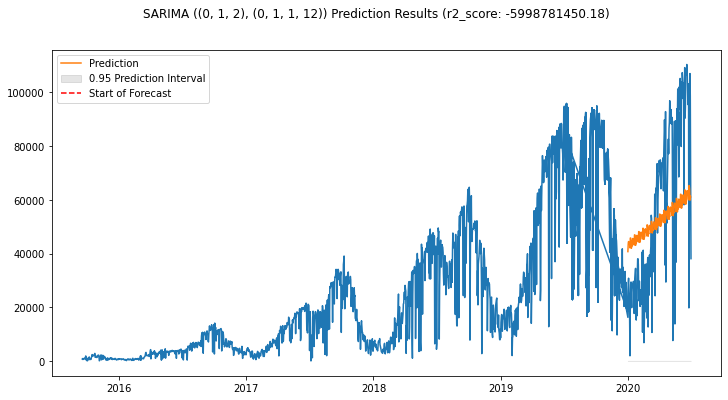

In [60]:
prediction = smodel_opt_fit.get_forecast(len(test_data))
predicted_value = np.exp(prediction.predicted_mean)
predicted_ub = prediction.conf_int()[:, 0]
predicted_lb = prediction.conf_int()[:, 1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(data)

ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color = 'k', alpha = 0.1, label = '0.95 Prediction Interval')
ax.vlines(test_data.index[0], 0,125, linestyle='--', color = 'r', label ='Start of Forecast')

ax.legend(loc = 'upper left')

plt.suptitle(f'SARIMA {sarima_model.order, sarima_model.seasonal_order} Prediction Results (r2_score: {round(r2, 2)})')
plt.show()